<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterator

In [2]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime, date, time, timezone, timedelta 

import os
import re

from functools import reduce
from collections import  defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Customer Analysis

In [3]:
os.listdir()

['.config',
 '1_orders_dataset.csv',
 'scanner_data.csv',
 'sample-sales-data.csv',
 'online_retail.xlsx',
 '1_order_payments_dataset.csv',
 'online_retail_II.xlsx',
 'mock_sales_data.csv',
 'sales_vs_discount.csv',
 'ecommerce-data.csv',
 'sales_data_with_stores.csv',
 'mall_customers.csv',
 'sales.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'groceries.csv',
 '1_customers_dataset.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'test.csv',
 'sample_data']

In [8]:
df = pd.read_csv('ecommerce-data.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [9]:
df.columns = ['_'.join(re.split('(?=[A-Z][a-z])', a[0].lower() + a[1:])).lower() for a in df.columns]
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [10]:
df = df[(~df.invoice_no.str.contains('C')) & (df.country == 'United Kingdom')]
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [12]:
df.invoice_date = pd.to_datetime(df.invoice_date)
df['date'] = df.invoice_date.to_numpy().astype('datetime64[D]')
df['month'] = df.invoice_date.to_numpy().astype('datetime64[M]')
df['rev'] = df.quantity * df.unit_price
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customerid,country,date,month,rev
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,20.34


In [13]:
df = df.groupby(['customerid', 'month', 'date'])['rev'].sum().reset_index().
df.head()

,customerid,month,date,rev
0,12346.0,2011-01-01,2011-01-18,77183.60
1,12747.0,2010-12-01,2010-12-05,358.56
2,12747.0,2010-12-01,2010-12-13,347.71
3,12747.0,2011-01-01,2011-01-20,303.04
4,12747.0,2011-03-01,2011-03-01,310.78


In [15]:
df = df.rename(columns = {'customerid':'id'})
df.head()

,id,month,date,rev
0,12346.0,2011-01-01,2011-01-18,77183.60
1,12747.0,2010-12-01,2010-12-05,358.56
2,12747.0,2010-12-01,2010-12-13,347.71
3,12747.0,2011-01-01,2011-01-20,303.04
4,12747.0,2011-03-01,2011-03-01,310.78


In [18]:
info_m = df.groupby(['id', 'month'])['rev'].sum().reset_index().rename(columns = {'rev':'money'})
info_m = pd.pivot_table(info_m, index='id', columns = 'month', values = 'money').reset_index()
info_m = pd.melt(info_m, id_vars = 'id', var_name = 'month', value_name = 'money').reset_index().sort_values(['id','month'], ascending = [1,0])
info_m = info_m.groupby(['id']).head(3)
info_m = info_m.groupby(['id'])['money'].sum().reset_index()
info_m.head()

,id,money
0,12346.0,0.00
1,12747.0,1426.61
2,12748.0,14002.34
3,12749.0,1335.65
4,12820.0,554.11


In [19]:
info_f = df.groupby(['id', 'month'])['rev'].count().reset_index().rename(columns = {'rev':'freq'})
info_f = pd.pivot_table(info_f, index='id', columns = 'month', values = 'freq').reset_index()
info_f = pd.melt(info_f, id_vars = 'id', var_name = 'month', value_name = 'freq').reset_index().sort_values(['id','month'], ascending = [1,0])
info_f = info_f.groupby(['id']).head(3)
info_f = info_f.groupby(['id'])['freq'].sum().reset_index()
info_f.head()

,id,freq
0,12346.0,0.0
1,12747.0,3.0
2,12748.0,33.0
3,12749.0,2.0
4,12820.0,2.0


In [20]:
max_date = df['date'].max() + pd.offsets.MonthEnd(0)
max_date

Timestamp('2011-12-31 00:00:00')

In [22]:
info_r = df.groupby(['id']).agg({'date' : lambda x : (max_date - x.max())}).reset_index().rename(columns = {'date':'recency'})
info_r['recency'] = info_r['recency'].dt.days
info_r.head()

,id,recency
0,12346.0,347
1,12747.0,24
2,12748.0,22
3,12749.0,25
4,12820.0,25


In [25]:
info = pd.merge(pd.merge(info_r, info_f, 'left', 'id'), info_m, 'left', 'id')
info = info.assign(
    r = pd.qcut(info.recency, 5, list('12345')).astype(int),
    f = pd.qcut(info.freq.rank(method = 'first'), 5, list('54321')).astype(int), 
    m = pd.qcut(info.money.rank(method = 'first'), 5, list('54321')).astype(int)
)
info.head()

,id,recency,freq,money,r,f,m
0,12346.0,347,0.0,0.00,5,5,5
1,12747.0,24,3.0,1426.61,1,1,1
2,12748.0,22,33.0,14002.34,1,1,1
3,12749.0,25,2.0,1335.65,1,2,1
4,12820.0,25,2.0,554.11,1,2,2


In [26]:
import plotly.express as px

In [28]:
cnt = info.groupby(['r','f', 'm'])['id'].count().reset_index().rename(columns = {'id':'cnt'})
cnt.head()

,r,f,m,cnt
0,1,1,1,373
1,1,1,2,98
2,1,1,3,21
3,1,2,1,45
4,1,2,2,64


In [32]:
px.scatter_3d(cnt, x = 'r', y = 'f', z = 'm', size = 'cnt', color = 'cnt')

# Iterator

In [38]:
names = np.random.choice(['park', 'choi', 'lee'], 100, replace = True)

def get_score(names) :

  unique, count = np.unique(names, return_counts = True)
  uniques = dict(zip(unique, count))

  res = list()

  for k, v in uniques.items() :

    s = np.random.randint(3, 10, 1)
    m = np.random.normal(50, 30, 1)
    score = [abs(a) if a <= 100 else 10 for a in np.random.normal(m, s, v) ]

    temp = pd.DataFrame({'name' : np.repeat(k, v),
                         'score' : score
                         })
    res.append(temp)
  
  res = pd.concat(res).reset_index()
  res.drop(['index'], axis = 1, inplace = True)
  return res

res = get_score(names)
res.head()

,name,score
0,choi,39.564210
1,choi,44.811123
2,choi,45.436490
3,choi,51.463854
4,choi,43.947744


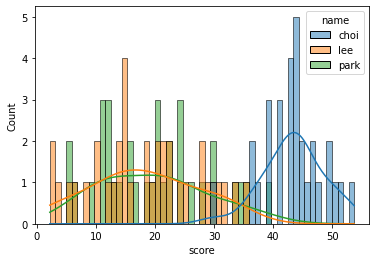

In [42]:
sns.histplot(data = res, x = 'score', hue = 'name', kde = True, bins = 55)